# Cats vs Dogs Classification: EDA & Modeling

This notebook demonstrates the end-to-end workflow for the **Cats vs Dogs** classification task.

## 1. Setup & Imports

In [1]:
%pip install seaborn ipykernel -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Exploratory Data Analysis (EDA)

First, let's explore the raw data. We expect the data to be in `../data/raw/`.

In [3]:
DATA_DIR = '../data/raw'
CATS_DIR = os.path.join(DATA_DIR, 'cats')
DOGS_DIR = os.path.join(DATA_DIR, 'dogs')

cat_files = [os.path.join(CATS_DIR, f) for f in os.listdir(CATS_DIR) if f.endswith('.jpg')]
dog_files = [os.path.join(DOGS_DIR, f) for f in os.listdir(DOGS_DIR) if f.endswith('.jpg')]

print(f"Total Cats: {len(cat_files)}")
print(f"Total Dogs: {len(dog_files)}")

Total Cats: 12499
Total Dogs: 12499


### 2.1 Class Distribution

/var/folders/k9/74m7jm7x3yz90gwk57wxjn9r0000gn/T/ipykernel_13634/3843654705.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Cats', 'Dogs'], y=[len(cat_files), len(dog_files)], palette='viridis')


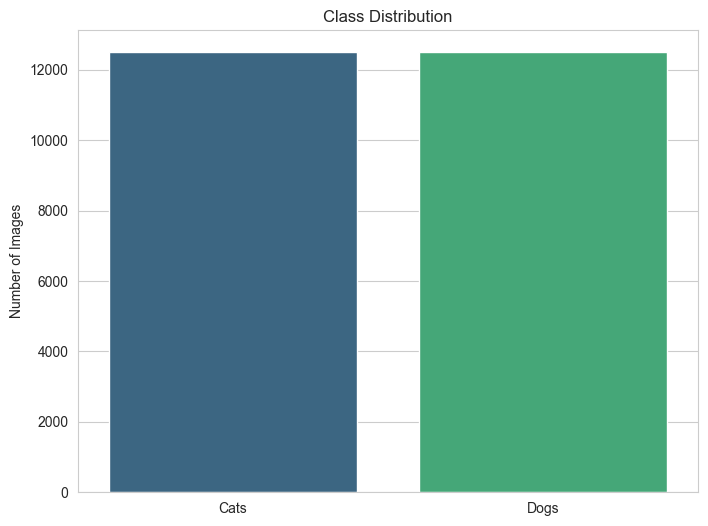

In [4]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['Cats', 'Dogs'], y=[len(cat_files), len(dog_files)], palette='viridis')
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.show()

### 2.2 Sample Images
Let's visualize some random samples from both classes.

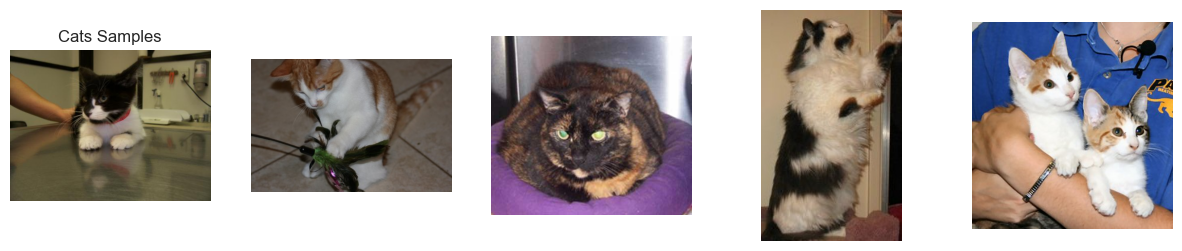

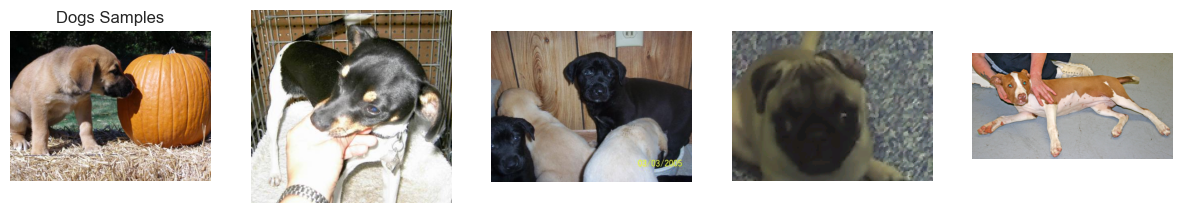

In [5]:
def show_samples(files, title, n=5):
    plt.figure(figsize=(15, 3))
    for i, filepath in enumerate(random.sample(files, n)):
        img = Image.open(filepath)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(title)
    plt.show()

show_samples(cat_files, "Cats Samples")
show_samples(dog_files, "Dogs Samples")

### 2.3 Image Size Analysis


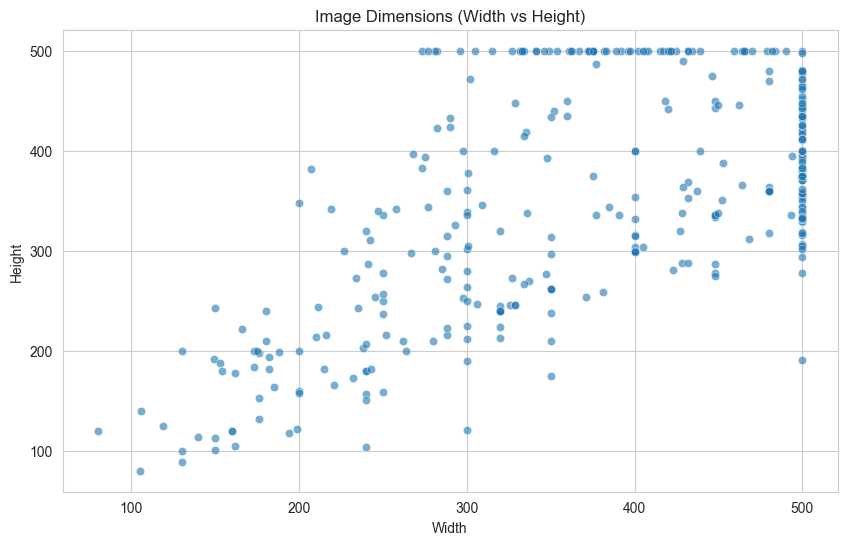

In [6]:
widths = []
heights = []

# Sample 500 images for speed
for filepath in random.sample(cat_files + dog_files, 500):
    try:
        with Image.open(filepath) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except:
        pass

plt.figure(figsize=(10, 6))
sns.scatterplot(x=widths, y=heights, alpha=0.6)
plt.title('Image Dimensions (Width vs Height)')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

## 3. Model Training

We will now train the `SimpleCNN` model defined in `src/model.py`. 
We use the helper functions from `src/data_preprocessing.py` to load and split the data.

In [7]:
from src.data_preprocessing import load_dataset, split_data, create_augmented_batch
from src.model import SimpleCNN, compute_accuracy

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.0005

print("Loading Data... (this may take a moment)")
# Load a subset for interactive training speed if needed, or full set
images, labels = load_dataset(DATA_DIR)
print(f"Loaded {len(images)} images.")

Loading Data... (this may take a moment)
Loaded 5000 cat images.          
Loaded total 10000 images (Cats + Dogs).          
Loaded 10000 images.


In [8]:
# Split Data
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(images, labels)

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (8000, 224, 224, 3)
Val shape: (1000, 224, 224, 3)
Test shape: (1000, 224, 224, 3)


In [ ]:
# Initialize Model
model = SimpleCNN(input_shape=(224, 224, 3), hidden_units=1024)

train_losses = []
val_accs = []

print("Starting Training...")
for epoch in range(EPOCHS):
    epoch_losses = []
    batch_gen = create_augmented_batch(X_train, y_train, BATCH_SIZE)
    steps = len(X_train) // BATCH_SIZE
    
    for _ in range(steps):
        bx, by = next(batch_gen)
        loss = model.train_step(bx, by, LR)
        epoch_losses.append(loss)
        
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    # Validation
    val_pred = model.predict(X_val)
    val_acc = compute_accuracy(y_val, val_pred)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

## 4. Evaluation

Let's visualize the training progress and evaluate on the test set.

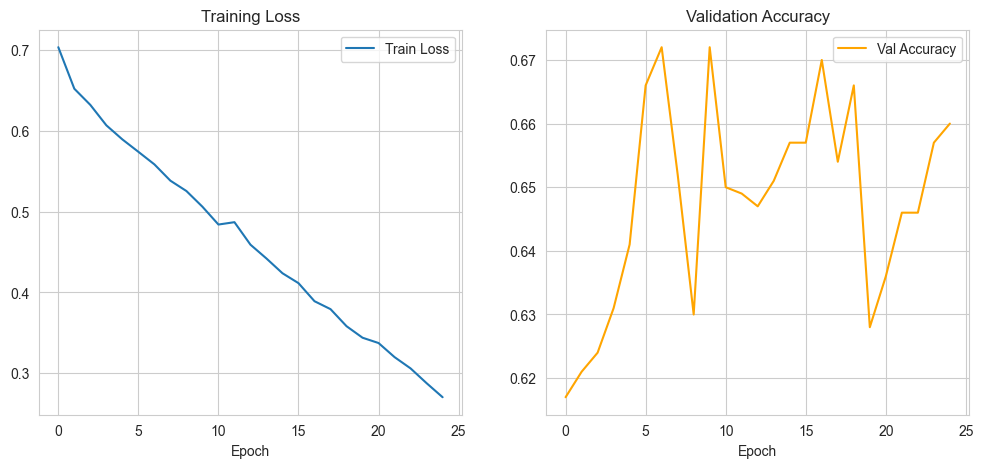

In [15]:
# Plot metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Val Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

Final Test Accuracy: 0.6100


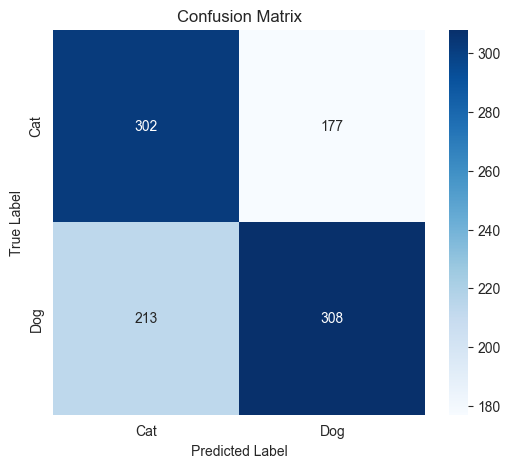

In [16]:
# Test Evaluation
test_pred = model.predict(X_test)
test_acc = compute_accuracy(y_test, test_pred)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Confusion Matrix Visualization
from src.model import compute_confusion_matrix
cm = compute_confusion_matrix(y_test, test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()